In [1]:
log_files = [
    'sequential_logs',
    'eventual_logs',
    'bounded_delay_10_logs'
]
log_description = ['sequential', 'eventual', 'bounded delay (10)']

In [2]:
numPartitions = 4

In [3]:
import pandas as pd
import numpy as np
    
def load_log(i, file_name):
    df_worker_tmp = pd.read_csv('./logs/' + file_name + '-worker.csv', sep=';')
    
    maxVC = [0 for i in range(numPartitions)]
    for p in range(numPartitions):
        maxVCWithinPartition = max(df_worker_tmp[df_worker_tmp['partition'] == p]['vectorClock'])
        maxVC[p] = max(maxVC[p], maxVCWithinPartition)
    maxVC = min(maxVC)
    
    df_worker_tmp = df_worker_tmp[df_worker_tmp['vectorClock'] <= maxVC].reset_index().sort_values('vectorClock')
    
    sumNumTuplesSeen = [0 for i in range(maxVC+1)]
    for p in range(numPartitions):
        for index, row in df_worker_tmp[df_worker_tmp['partition'] == p].iterrows():
            vc = int(row['vectorClock'])
            sumNumTuplesSeen[vc] += row['numTuplesSeen']
            
    
    df_server_tmp = pd.read_csv('./logs/' + file_name + '-server.csv', sep=';')
    df_server_tmp['numTuplesSeen'] = sumNumTuplesSeen
    df_server_tmp['file_id'] = i
    return df_server_tmp
    
    
df = pd.concat([load_log(i, file_name) for i, file_name in enumerate(log_files)])

In [4]:
df.sample(5)

,timestamp,partition,vectorClock,loss,fMeasure,accuracy,numTuplesSeen,file_id
179,1584309650258,-1,179,-1,0.369012,0.376666,3982.0,2
445,1584305739583,-1,445,-1,0.386621,0.382817,5884.0,1
422,1584304114180,-1,422,-1,0.399825,0.406807,8838.0,0
35,1584309139949,-1,35,-1,0.338329,0.353496,1510.0,2
186,1584303197876,-1,186,-1,0.384474,0.394505,4309.0,0


In [5]:
maxNumTuplesSeen = [0 for i in range(len(log_files))]
for p in range(len(log_files)):
    maxWithinFile = max(df[df['file_id'] == p]['numTuplesSeen'])
    maxNumTuplesSeen[p] = max(maxNumTuplesSeen[p], maxWithinFile)
maxNumTuplesSeen = min(maxNumTuplesSeen)
#maxVC = 576
maxNumTuplesSeen

9985.0

In [6]:
#df = df[df['numTuplesSeen'] <= maxNumTuplesSeen].reset_index().sort_values('numTuplesSeen')

In [7]:
data = {
    **{'fMesaure'+str(i): [] for i in range(len(log_files))},
    **{'accuracy'+str(i): [] for i in range(len(log_files))},
    **{'numTuplesSeen'+str(i): [] for i in range(len(log_files))}
}

for p in range(len(log_files)):
    for index, row in df[df['file_id'] == p].iterrows():
        data['fMesaure'+str(p)] += [row['fMeasure']]
        data['accuracy'+str(p)] += [row['accuracy']]
        data['numTuplesSeen'+str(p)] += [row['numTuplesSeen']]

In [8]:
#data = pd.DataFrame(data)

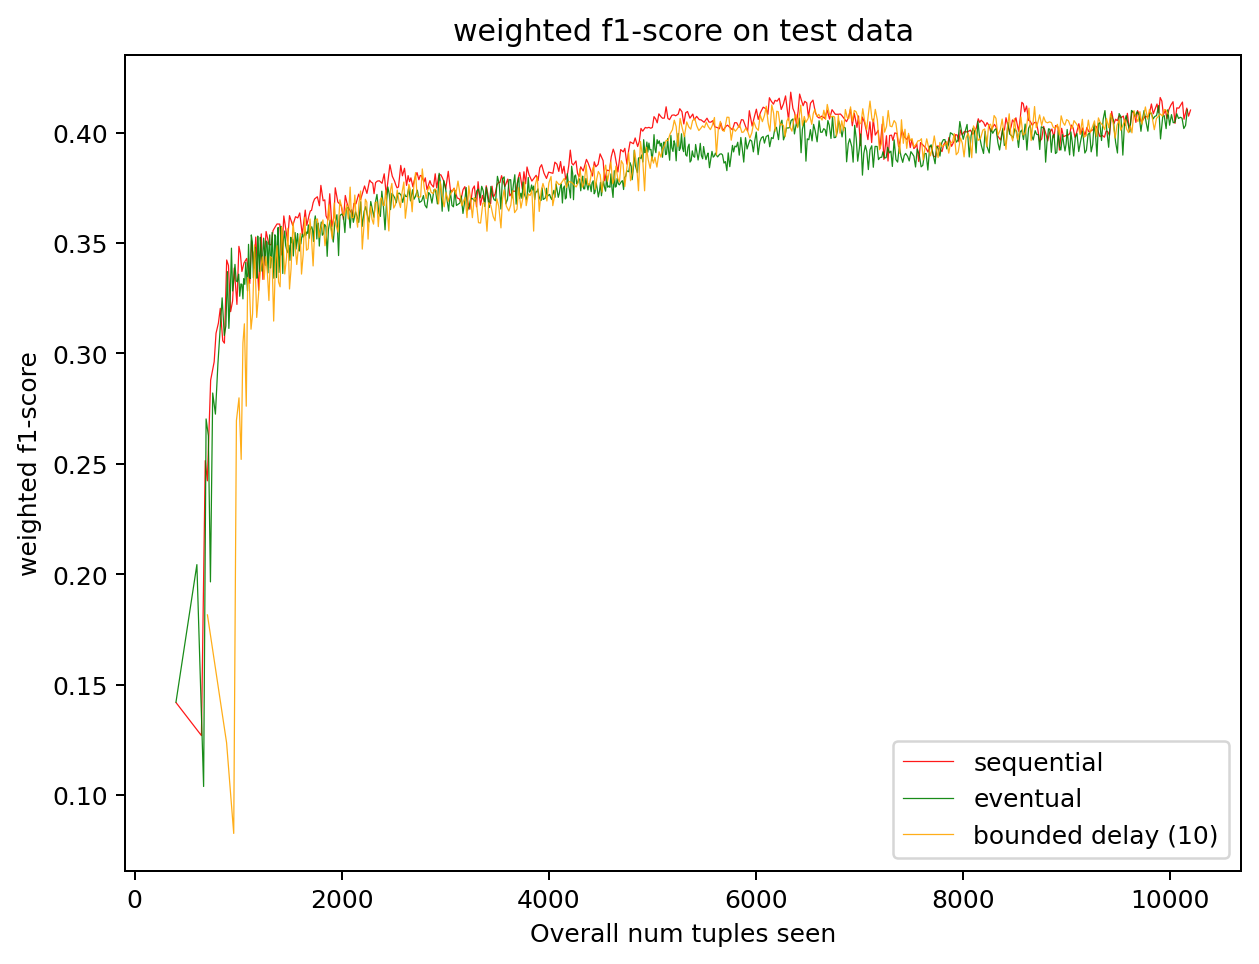

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

#data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'green', 'orange', 'purple']

for i in range(len(log_files)):
    colY = 'fMesaure' + str(i)
    colX = 'numTuplesSeen' + str(i)
    
    alpha = 0.9
    
    label = log_description[i]
    
    linewidth = 0.5
    plt.plot(data[colX], data[colY], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('weighted f1-score on test data')
plt.ylabel('weighted f1-score')
plt.xlabel('Overall num tuples seen')
plt.legend(loc=4, ncol=1)
plt.show()

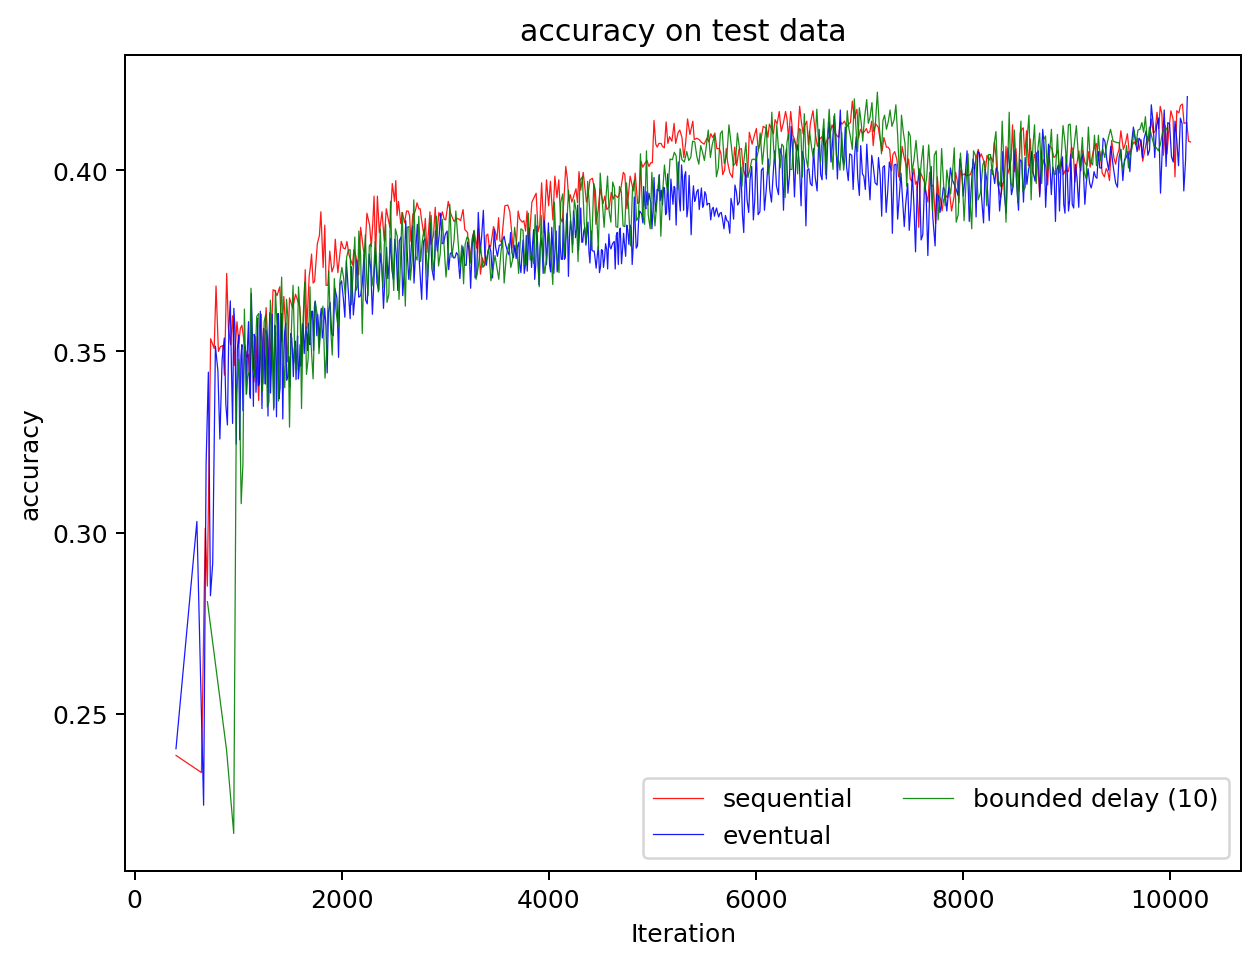

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(len(log_files)):
    colY = 'accuracy' + str(i)
    colX = 'numTuplesSeen' + str(i)
    
    alpha = 0.9
    
    label = log_description[i]
    
    linewidth = 0.5
    plt.plot(data[colX], data[colY], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('accuracy on test data')
plt.ylabel('accuracy')
plt.xlabel('Iteration')
plt.legend(loc=4, ncol=2)
plt.show()